In [1]:
from hypothesis import strategies as st
from hypothesis.extra.numpy import arrays
from scipy.interpolate import CubicSpline



https://docs.scipy.org/doc/scipy-1.16.0/tutorial/interpolate.html#tutorial-interpolate
fft?

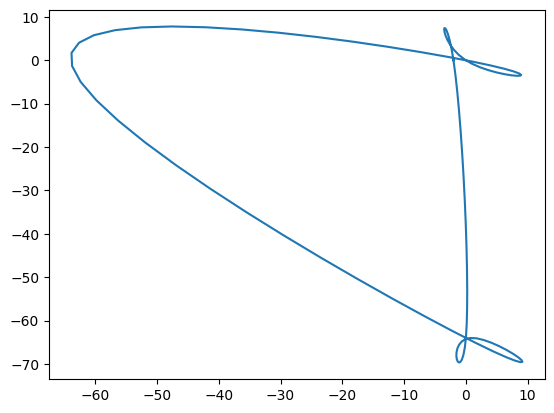

In [22]:
import numpy as np
import scipy.interpolate as interp

@st.composite
def contour(draw):
    n = draw(st.integers(min_value=3, max_value=10))
    ts = np.linspace(0, 1, n)
    pts = draw(arrays(np.float64, (n, 2), elements=st.floats(min_value=-100,max_value=100, allow_nan=False, allow_infinity=False)))
    pts[0,:] = pts[-1,:]  # Make it periodic
    #print(ts, pts)
    #return interp.make_interp_spline(ts, pts, bc_type="periodic")
    return CubicSpline(ts, pts, bc_type="periodic")

spl = contour().example()
ts = np.linspace(0, 1, 100)
pts = spl(ts)
import matplotlib.pyplot as plt
plt.plot(pts[:, 0], pts[:, 1])

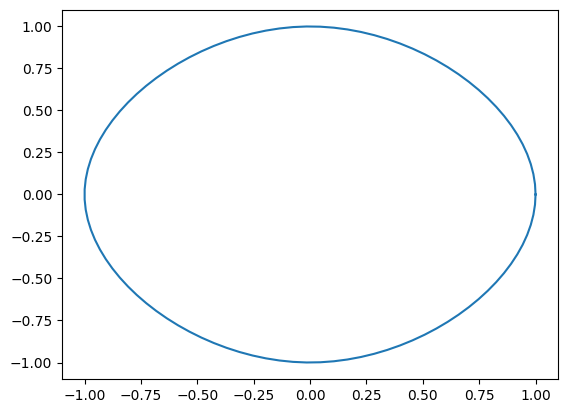

In [ ]:
def circle(r): # r, c
    return CubicSpline([0, 1/4, 1/2, 3/4, 1], 
                       [[r, 0], [0, r], [-r, 0], [0, -r], [r, 0]], 
                       bc_type="periodic")
plt.plot(*circle(1)(ts).T)

https://en.wikipedia.org/wiki/Smoothness 
https://en.wikipedia.org/wiki/Function_(mathematics)
https://en.wikipedia.org/wiki/Function_space 

monotonic
convex
compact support
cinf smooth vs Cw analytic
Lp spaces https://en.wikipedia.org/wiki/Lp_space
https://en.wikipedia.org/wiki/Lipschitz_continuous


https://en.wikipedia.org/wiki/Sequence_space

https://en.wikipedia.org/wiki/Banach_space

def banach():
    return (fun_strat, norm)

Spaces ~ Types... Checkers + Generators

Counterexamples in analysis. Take them. bake them in.
Things like the dirchlet function (continoous but differential nowhere) are so shitty that I don't know how they can be shown numerically /

Contructivism bishop
Interval analysis. functional interval analysis


In [ ]:
@st.composite
def goodfun(draw):
    st.one_of([lambda x: st.float(), # const
              lambda x: x,  # id
              np.pow( n),
               np.exp, np.sin, np.cos, np.tan, np.sinh, np.cosh, np.tanh,
     np.log, np.sqrt, np.abs, np.arcsin, np.arccos])

     def rec(f):
        st.tuple(f,f).flatmap(lambda fg: lambda x: fg[0](x) + fg[1](x),  # add
            lambda x: fg[0](fg[1](x)),  # compose
            lambda x: fg[0](x) * fg[1](x),  # multiply
            lambda x: fg[0](x) / fg[1](x),  # divide
            lambda x: fg[0](x) ** fg[1](x),  # power

def C1():
    piecewise | cC2
def C2():
    cubic | Cinf


def Cn():

def Cinf():

def L1():

def L2():

def lipshitz(eps)


np.sin(1/x) # good counterexample

https://www.philipzucker.com/Reals_from_intervals/
https://www.philipzucker.com/z3-cegar-interval/ I guess this approach is kind of interesting as a decentralized emitting of constraints. But it is often the case that centralized and monolithic is simpler and the extensiblity is not that relevant if I can keep changing my code.
user propagators



dreal
This can be considered as a tactic also. Everything is via instantiating axioms from kd.reals
cvc5

The polya ln trick. x*y == exp(ln(x) + ln(z)) 
hmm. Z3 is the perfect blackboard / whiteboard

Hmm. z3.substitute might be faster than building new terms. Interesting

But might not be faster if we had better bindings... maybe. This is microopptimization. I a priori know what positions to suvbstitute into
unop = {
"sin" : 
}

could do range reduction
t == x + pi*n
-pi <= x <= pi
sin(t) == sin(x)

`forall a, exists x, -pi <= x <= pi, sin(x) = sin(a)` is a weaker version of periodicity that avoids mixed int real theory.
FreshConst("x")
-pi <= x <= pi  
sin(x) == sin(t)

In [ ]:
from kdrag.all import *
import kdrag.theories.real as real



class TransSolver():
    #unop = {
    #"sin" : lambda arg0 : smt.And(real.sin(arg0) <= 1, real.sin(arg0) >= -1, real.sin(0) == 0, smt.Implies(arg >= 0, t <= arg), smt.Implies(real.sin(arg) <= 0, t >= arg))
    #}
    def __init__(self):
        self.solver = smt.Solver()
        # Really basic facts
        self.solver.add(sin(0) == 0) # cos_zero.thm
        self.solver.add(cos(0) == 1)
        self.ts = []
        self.eps = 0.0001
    def add(self, constr):
        self.solver.add(constr)
        todo = [constr]
        while todo:
            t = todo.pop()
            if smt.is_app(t):
                todo.extend(t.children())
                name = t.decl().name()
                if name in ["sin", "cos"]: # self.unop  "tan", "exp", "log", "sqrt"
                    # add cheap constraints. linear, bounds, constants. Anything nonlinear is iffier.
                    self.ts.append(t)
                    arg = t.args(0)
                    if name == "sin":
                        self.solver.add(smt.And(t >= -1, t <= 1))
                        self.solver.add(t == -real.sin(-arg)) # antisymettry
                        self.solver.add(smt.Implies(arg >= 0, t <= arg)) # sin(x) <= x   for x >= 0
                        self.solver.add(smt.Implies(arg <= 0, t >= arg))
    def check(self):
        while self.solver.check() == smt.sat:
            # tighten using model
            # tighten all? Tighten worst? Anything with error larger than current epsilon?
            model = self.solver.model()
            for t in self.ts:
                name = t.decl().name()
                if name == "sin":
                    x = model.eval(t.args(0))
                    # use munoz bounds
                    # Or use arb?
        self.ts.append(constr)

#elif name == "exp":
#    self.solver.add(t > 0)
#    self.solver.add(t >= 1 + t.args(0))
#    self.solver.add(exp(0) == 1)
#pass